In [1]:
! git clone https://github.com/pwy7fv/labs

Cloning into 'labs'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 92 (delta 31), reused 18 (delta 18), pack-reused 53 (from 1)
Receiving objects: 100% (92/92), 2.76 MiB | 5.55 MiB/s, done.
Resolving deltas: 100% (38/38), done.


# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/jwa#search=1~gallery~0~89'
raw = requests.get(url,headers=header)

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

## 2. Get your search results of interest and extract data from them, using code similar to what's above.

In [7]:
from bs4 import BeautifulSoup as soup
bsObj = soup(raw.content,'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

In [8]:
print(listings)

[<li class="cl-static-search-result" title="Musical Jewelry Box">
<a href="https://charlottesville.craigslist.org/jwl/d/troy-musical-jewelry-box/7783136098.html">
<div class="title">Musical Jewelry Box</div>
<div class="details">
<div class="price">$10</div>
<div class="location">
                        Louisa
                    </div>
</div>
</a>
</li>, <li class="cl-static-search-result" title="Jewelry">
<a href="https://charlottesville.craigslist.org/jwl/d/troy-jewelry/7783920615.html">
<div class="title">Jewelry</div>
<div class="details">
<div class="price">$1</div>
</div>
</a>
</li>, <li class="cl-static-search-result" title="2 Pair Ear Rings">
<a href="https://charlottesville.craigslist.org/jwl/d/troy-pair-ear-rings/7783926088.html">
<div class="title">2 Pair Ear Rings</div>
<div class="details">
<div class="price">$5</div>
</div>
</a>
</li>, <li class="cl-static-search-result" title="Assorted Watches">
<a href="https://charlottesville.craigslist.org/jwl/d/culpeper-assorted-wa

In [24]:
import re


types = ['ring','rings','watch','watches','earrings','earring','necklace','necklaces','box','boxes','band']

data = []
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']

    words = title.split()
    hits = [word for word in words if word in types]
    found_type = hits[0] if hits else 'missing'

    data.append({'title':title,'price':price,'link':link,'types':found_type})

In [25]:
print(data)

[{'title': 'musical jewelry box', 'price': '$10', 'link': 'https://charlottesville.craigslist.org/jwl/d/troy-musical-jewelry-box/7783136098.html', 'types': 'box'}, {'title': 'jewelry', 'price': '$1', 'link': 'https://charlottesville.craigslist.org/jwl/d/troy-jewelry/7783920615.html', 'types': 'missing'}, {'title': '2 pair ear rings', 'price': '$5', 'link': 'https://charlottesville.craigslist.org/jwl/d/troy-pair-ear-rings/7783926088.html', 'types': 'rings'}, {'title': 'assorted watches', 'price': '$1', 'link': 'https://charlottesville.craigslist.org/jwl/d/culpeper-assorted-watches/7785669568.html', 'types': 'watches'}, {'title': "14k white gold men's wedding band- newly purchased", 'price': '$1,200', 'link': 'https://charlottesville.craigslist.org/jwl/d/culpeper-14k-white-gold-mens-wedding/7784828929.html', 'types': 'missing'}, {'title': 'new sterling silver ring size 9', 'price': '$45', 'link': 'https://charlottesville.craigslist.org/jwl/d/quinque-new-sterling-silver-ring-size/77837613

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [27]:

df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('craigslist_cville_jewelry.csv')
print(df)

(23, 4)
                                                title  price  \
0                                 musical jewelry box     10   
1                                             jewelry      1   
2                                    2 pair ear rings      5   
3                                    assorted watches      1   
4   14k white gold men's wedding band- newly purch...   1200   
5                     new sterling silver ring size 9     45   
6   > ladies ring - amethyst, diamonds & 10k gold,...      0   
7                                2 louis vuitton bags    500   
8                                   older jewelry box     10   
9   blue cat’s eye pendant with antiqued, polished...     30   
10  gold glass heart pendant crystal bead necklace...     15   
11                                      bunch watches     10   
12                        halloween earring set of 5!     10   
13                    brand new necklaces & pendents!     15   
14                              

In [29]:
df.head()

,title,price,link,types
0,musical jewelry box,10,https://charlottesville.craigslist.org/jwl/d/t...,box
1,jewelry,1,https://charlottesville.craigslist.org/jwl/d/t...,missing
2,2 pair ear rings,5,https://charlottesville.craigslist.org/jwl/d/t...,rings
3,assorted watches,1,https://charlottesville.craigslist.org/jwl/d/c...,watches
4,14k white gold men's wedding band- newly purch...,1200,https://charlottesville.craigslist.org/jwl/d/c...,missing


With the data in and wrangled, we can now do EDA:

count      23.000000
mean      100.347826
std       261.939897
min         0.000000
25%         7.500000
50%        15.000000
75%        42.500000
max      1200.000000
Name: price, dtype: float64


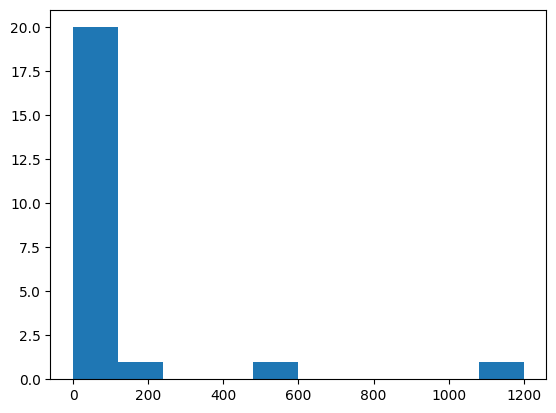

count          23
unique         10
top       missing
freq            8
Name: types, dtype: object


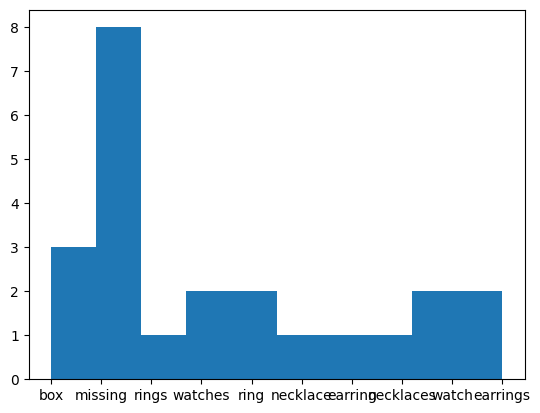

In [30]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['types'].describe())
df['types'].hist(grid=False)
plt.show()

In [32]:
df.loc[:,['price','types']].groupby('types').describe()

price                                                              
          count        mean         std    min     25%    50%     75%     max
types                                                                        
box         3.0   18.333333   14.433757   10.0   10.00   10.0   22.50    35.0
earring     1.0   10.000000         NaN   10.0   10.00   10.0   10.00    10.0
earrings    2.0   35.000000    7.071068   30.0   32.50   35.0   37.50    40.0
missing     8.0  225.875000  428.564193    1.0    4.00   25.0  162.50  1200.0
necklace    1.0   15.000000         NaN   15.0   15.00   15.0   15.00    15.0
necklaces   1.0   15.000000         NaN   15.0   15.00   15.0   15.00    15.0
ring        2.0   22.500000   31.819805    0.0   11.25   22.5   33.75    45.0
rings       1.0    5.000000         NaN    5.0    5.00    5.0    5.00     5.0
watch       2.0  137.500000   53.033009  100.0  118.75  137.5  156.25   175.0
watches     2.0    5.500000    6.363961    1.0    3.25    5.5    7.75    10.0

## 4. From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.

The final thing we want to do is go from scraping a single page to crawling around.

The idea here is that every web page is connected to some other page. By extracting links as we move from page to page, we can create a web crawler that wanders around for us, gathering information of interest.

In this case, we want to use the search results to then visit each individual page for each listing. Since we saved the links to the web pages in the previous scrape, we can now simply for-loop over that column in the dataframe, visiting the page listing for each of the cars in the search results:

What are the new features here?

First, we don't want to overwhelm the servers, so we put a small delay between each request of a listing, `time.sleep(random.randint(1, 3))`. This waits a random amount of time between 1 and 3 seconds to avoid overwhelming their server.

Second, we use the try/except block. This is a useful control structure in general, but especially for web scraping. Python tries the statements under `try:`, and if it fails, executes the steps under `except:`. This can happen, in this case, with missing data, which crashes the crawler. Instead, we put our missing codes into our dataframe right away.

Third, we used `.find().find().get_text()` to find the data we're looking for. In general, the structure of mark-up langauges like HTML and XML makes it possible to "drill down" into their entries and extract the information of interest. This exploitation of mark-up languages could be the subject of a whole course on procuring data from the web.

With the data scraped, we can make a new dataframe, combine it with the old one using `pd.concat`, and do some wrangling to clean the data up: